In [2]:
#Mount Google Drive to import Train/Test dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#import libraries
import torch
from torch import nn
import glob
import numpy as nn
import matplotlib.pyplot as plt

torch.__version__

import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
from torchvision.datasets import DatasetFolder

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets

from torchsummary import summary
from tqdm.notebook import trange, tqdm

In [4]:
#set up device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
import torch
from torchvision.datasets import DatasetFolder
from torchvision.transforms import transforms
from PIL import Image


class OriginalDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []

        # Load all the images in the root folder
        for filename in os.listdir(root):
            if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                self.images.append(os.path.join(root, filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img)

        return img, 0  # Return a dummy label '0'

#define transforms
transform = transforms.Compose([
    transforms.Resize(size=(28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#define train and test path to find images
train_path = "/content/drive/MyDrive/CPSC_5440/Assignment3/data/train"
test_path = "/content/drive/MyDrive/CPSC_5440/Assignment3/data/test1"

#create train dataset w/ transforms
train_dataset = OriginalDataset(train_path, transform=transform)

#create test dataset w/ transforms
test_dataset = OriginalDataset(test_path, transform=transform)

#create train dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 3000, shuffle = True)

#create test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 3000, shuffle = True)



In [6]:
#print length of train/test dataloader
len(train_dataloader), len(test_dataloader)

(9, 5)

In [7]:
#define hyperparameters
latent_dims = 80
EPOCHS = 20
cap = 16
learning_rate = 1e-3
upe_gpu = True

In [8]:
#define Encoder class
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    c = cap
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=2, stride=2, padding=1) #out: c x 14 x 14 in: c x 28 x 28
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=2, stride=2, padding=1) #out: c x 7 x 7 in: c x 14 x 14
    self.conv3 = nn.Conv2d(c*2, c*4, 2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    return x

#define Decoder class
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    c = cap
    self.conv3 = nn.ConvTranspose2d(c*4, c*2, 2)
    self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=2, stride=2, padding=1, output_padding=1)
    self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=2, stride=2, padding=1, output_padding=1)
    self.conv0 = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=2, stride=2, padding=1, output_padding=1)

  def forward(self, x):
    c = cap
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv1(x))
    x = torch.sigmoid(self.conv0(x))
    return x

#define Autoencoder class
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    latent = self.encoder(x)
    x_recon = self.decoder(latent)
    return x_recon

In [9]:
#define object of Autoencoder class
autoencoder = Autoencoder()

#set up device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
autoencoder = autoencoder.to(device)

#calculate parameters
num_parameters = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print("# of parameters: ", num_parameters)
print(autoencoder)
print(device)

# of parameters:  20912
Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  )
  (decoder): Decoder(
    (conv3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
    (conv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv0): ConvTranspose2d(3, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)
cpu


In [10]:
#start training
#define optimizer 
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

train_loss_avg = []

print("Training ------------------------")
for epoch in range(EPOCHS):
  train_loss_avg.append(EPOCHS)
  num_batches = 0

  for (image_batch, _) in tqdm(train_dataloader, desc = "Processing items"):

    image_batch = image_batch.to(device)

    image_batch_reconstruction = autoencoder(image_batch)
    image_batch = torch.nn.functional.interpolate(image_batch, size = 57, mode = 'bilinear', align_corners=False)
    loss = F.mse_loss(image_batch_reconstruction, image_batch)

    #backward propagation
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    train_loss_avg[-1] += loss.item()
    num_batches += 1

  train_loss_avg[-1] /= num_batches
  print("Epoch [%d / %d] average reconstruction error: %f" % (epoch+1, EPOCHS, train_loss_avg[-1]))

Training ------------------------


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1 / 20] average reconstruction error: 2.761804


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2 / 20] average reconstruction error: 2.753421


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3 / 20] average reconstruction error: 2.740289


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4 / 20] average reconstruction error: 2.721041


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5 / 20] average reconstruction error: 2.701689


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6 / 20] average reconstruction error: 2.690889


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7 / 20] average reconstruction error: 2.678615


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8 / 20] average reconstruction error: 2.669682


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9 / 20] average reconstruction error: 2.661658


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10 / 20] average reconstruction error: 2.652971


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11 / 20] average reconstruction error: 2.644728


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12 / 20] average reconstruction error: 2.636807


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13 / 20] average reconstruction error: 2.628963


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14 / 20] average reconstruction error: 2.618882


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15 / 20] average reconstruction error: 2.606074


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16 / 20] average reconstruction error: 2.579696


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17 / 20] average reconstruction error: 2.531214


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18 / 20] average reconstruction error: 2.508255


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19 / 20] average reconstruction error: 2.502958


Processing items:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20 / 20] average reconstruction error: 2.499408


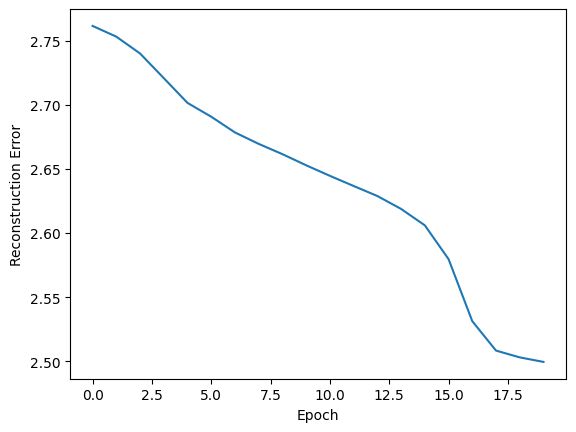

In [11]:
#Plot training curve
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.show()

In [12]:
#evaluate test set
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in tqdm(test_dataloader, desc="Processing Items"):

  with torch.no_grad():

    image_batch = image_batch.to(device)

    image_batch_reconstruction = autoencoder(image_batch)
    image_batch = torch.nn.functional.interpolate(image_batch, size = 57, mode='bilinear', align_corners=False)
    lose = F.mse_loss(image_batch_reconstruction, image_batch)

    test_loss_avg += loss.item()
    num_batches += 1

test_loss_avg /= num_batches
print("Average reconstruction error: %f" % (test_loss_avg))

Processing Items:   0%|          | 0/5 [00:00<?, ?it/s]

Average reconstruction error: 0.277637


Original images


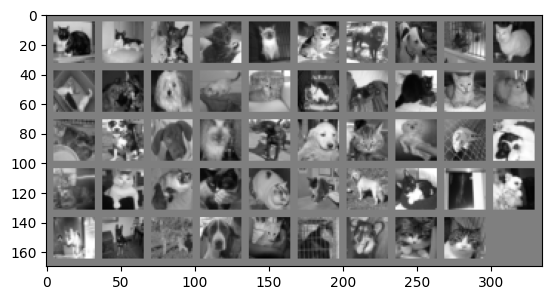

Autoencoder reconstruction:


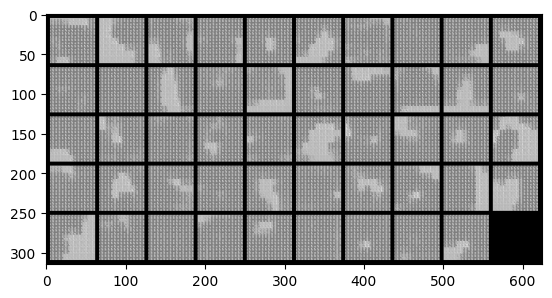

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

#function to take in an image and the model with which the reconstruction is performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)
